In [51]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [45]:
class CATE_conjugateBayes_merge:
    def __init__(self, prior='normal', likelihood='normal', prior_hyperparameters=None):
        self.prior = prior
        self.likelihood = likelihood
        self.prior_hyperparameters = prior_hyperparameters
        self.posterior_params = None

        self._check_prior_hyperparameters()

    def _check_prior_hyperparameters(self):
        if self.prior_hyperparameters is None:
            return

        if self.prior == 'normal':
            required_keys = ['mean', 'std']
        elif self.prior == 'cauchy':
            required_keys = ['alpha', 'beta']
        elif self.prior == 'jeffreys':
            required_keys = ['sigma']
        else:
            raise ValueError("Invalid prior. Currently supported priors: 'normal', 'cauchy', 'jeffreys'.")

        for key in required_keys:
            if key not in self.prior_hyperparameters:
                raise ValueError(f"Missing hyperparameter '{key}' for the chosen prior '{self.prior}'.")

    def fit(self, X, T, Y):
        # Calculate posterior parameters based on the chosen prior
        if self.prior == 'normal':
            prior = stats.norm(loc=self.prior_hyperparameters['mean'], scale=self.prior_hyperparameters['std'])
        elif self.prior == 'cauchy':
            prior = stats.cauchy(loc=self.prior_hyperparameters['alpha'], scale=self.prior_hyperparameters['beta'])
        elif self.prior == 'jeffreys':
            prior = stats.norm(loc=0, scale=self.prior_hyperparameters['sigma'])
        else:
            raise ValueError("Invalid prior. Currently supported priors: 'normal', 'cauchy', 'jeffreys'.")

        # Calculate posterior parameters using a simplified formula
        posterior_mean = (prior.std()**2 * X * T + prior.mean()) / (prior.std()**2 * T**2 + 1)
        posterior_std = np.sqrt(prior.std()**2 / (prior.std()**2 * T**2 + 1))

        posterior = np.random.normal(loc=posterior_mean, scale=posterior_std, size=len(X))

        self.posterior_params = {'mean': np.mean(posterior), 'std': np.std(posterior)}

        return posterior



In [46]:
# Generate datasets
np.random.seed(42)

# Sigmoid function for treatment assignment
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

n_host = 1000
X_host = np.random.normal(2, 1, n_host)
T_host = sigmoid(1 + 2 * X_host + np.random.normal(0, 1, n_host))
Y_host = 1 + 2 * X_host + 2 * T_host + np.random.normal(0, 1, n_host)

n_candidate = 1000
X_cand = np.random.normal(2, 1, n_candidate)
T_cand = sigmoid(1 + 2 * X_cand + np.random.normal(0, 1, n_candidate))
Y_cand = 1 + 2 * X_cand + 2 * T_cand + np.random.normal(0, 1, n_candidate)



In [47]:
# Initialize CATE_conjugateBayes_merge
cate_bayes = CATE_conjugateBayes_merge(likelihood='normal', prior='normal', prior_hyperparameters={'mean': 0, 'std': 1})

# Bayesian pass over the CATE function using the host data
posterior_host = cate_bayes.fit(X_host, T_host, Y_host)

# Bayesian pass over the CATE function using the host data
posterior_cand = cate_bayes.fit(X_cand, T_cand, Y_cand)



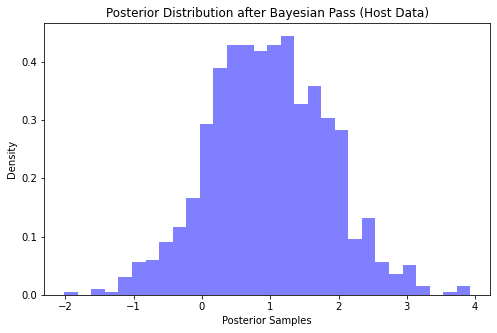

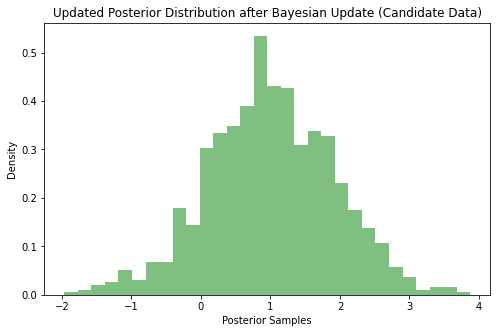

In [49]:
# Plot posterior after the Bayesian pass over the CATE function using the host data
plt.figure(figsize=(8, 5))
plt.hist(posterior_host, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Posterior Distribution after Bayesian Pass (Host Data)')
plt.xlabel('Posterior Samples')
plt.ylabel('Density')
plt.show()


# Plot updated posterior after the Bayesian update using the candidate data
plt.figure(figsize=(8, 5))
plt.hist(posterior_cand, bins=30, density=True, alpha=0.5, color='green')
plt.title('Updated Posterior Distribution after Bayesian Update (Candidate Data)')
plt.xlabel('Posterior Samples')
plt.ylabel('Density')
plt.show()

In [53]:
# Assuming posterior_host and posterior_cand are the posterior distributions
epsilon = 1e-10  
# Small constant to avoid division by zero
# Happens when the support are disjoints

# Clip values to avoid zeros in the denominator
posterior_host_clipped = np.clip(posterior_host, epsilon, None)
posterior_cand_clipped = np.clip(posterior_cand, epsilon, None)

kl_divergence = entropy(posterior_host_clipped, qk=posterior_cand_clipped)

print(f"KL Divergence between posteriors: {kl_divergence}")

KL Divergence between posteriors: 3.2813770643965428
